In [0]:
'''We used this link:
https://github.com/Turanga1/Automated-Essay-Scoring/blob/master/0_EDA_and_Topic_Modeling_with_LDA.ipynb
as a guide on how to to do Topic Modeling on an essay set like this.'''

'We used this link:\nhttps://github.com/Turanga1/Automated-Essay-Scoring/blob/master/0_EDA_and_Topic_Modeling_with_LDA.ipynb\nas a guide on how to to do Topic Modeling on an essay set like this.'

# Importing Libraries Needed

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import nltk 
import spacy 
import language_check

from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\teena\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\teena\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading The Data Into Python

In [0]:
training_dataset = pd.read_csv("C:/Users/teena/Downloads/training_set_rel3.tsv", sep = '\t', encoding = "ISO-8859-1")

In [0]:
testing_dataset = pd.read_csv("C:/Users/teena/Downloads/test_set.tsv", sep = '\t', encoding = "ISO-8859-1")

# Exploratory Data Analysis and Data Cleaning

In [0]:
#Loading the columns in the training dataset
training_dataset.columns

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'rater3_domain1', 'domain1_score', 'rater1_domain2', 'rater2_domain2',
       'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3',
       'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1',
       'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5',
       'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3',
       'rater3_trait4', 'rater3_trait5', 'rater3_trait6'],
      dtype='object')

In [0]:
#Gathering information about data types within the columns 
training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
essay_id          12976 non-null int64
essay_set         12976 non-null int64
essay             12976 non-null object
rater1_domain1    12976 non-null int64
rater2_domain1    12976 non-null int64
rater3_domain1    128 non-null float64
domain1_score     12976 non-null int64
rater1_domain2    1800 non-null float64
rater2_domain2    1800 non-null float64
domain2_score     1800 non-null float64
rater1_trait1     2292 non-null float64
rater1_trait2     2292 non-null float64
rater1_trait3     2292 non-null float64
rater1_trait4     2292 non-null float64
rater1_trait5     723 non-null float64
rater1_trait6     723 non-null float64
rater2_trait1     2292 non-null float64
rater2_trait2     2292 non-null float64
rater2_trait3     2292 non-null float64
rater2_trait4     2292 non-null float64
rater2_trait5     723 non-null float64
rater2_trait6     723 non-null float64
rater3_trait1     128

In [0]:
#Finding the number of records for each column for each of the eight essay sets
training_dataset.groupby('essay_set').agg('count')

,essay_id,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
essay_set,,,,,,,,,,,,,,,,,,,,,
1,1783,1783,1783,1783,0,1783,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1800,1800,1800,1800,0,1800,1800,1800,1800,0,...,0,0,0,0,0,0,0,0,0,0
3,1726,1726,1726,1726,0,1726,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1770,1770,1770,1770,0,1770,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1805,1805,1805,1805,0,1805,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1800,1800,1800,1800,0,1800,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1569,1569,1569,1569,0,1569,0,0,0,1569,...,1569,1569,0,0,0,0,0,0,0,0
8,723,723,723,723,128,723,0,0,0,723,...,723,723,723,723,128,128,128,128,128,128


In [0]:
#This function finds the pecentage of null values 
def nulls(df):
    nulls = pd.DataFrame(round(df.isnull().sum()/len(df.index)*100,2),columns=['null_percent'])
    return nulls[nulls['null_percent']!=0.00].sort_values('null_percent',ascending=False)
nulls(training_dataset)

,null_percent
rater3_domain1,99.01
rater3_trait1,99.01
rater3_trait5,99.01
rater3_trait4,99.01
rater3_trait3,99.01
rater3_trait2,99.01
rater3_trait6,99.01
rater1_trait5,94.43
rater1_trait6,94.43
rater2_trait5,94.43


In [0]:
#This drops the columns which have more than 90% of null values 
training_dataset = training_dataset.drop(columns = [
       'rater3_domain1', 'rater1_trait5', 'rater1_trait6', 'rater2_trait5',
       'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3',
       'rater3_trait4', 'rater3_trait5', 'rater3_trait6'])

In [0]:
#This creates a column called word count 
training_dataset['word_count'] = training_dataset['essay'].str.strip().str.split().str.len()

Text(0, 0.5, 'Average Word Count')

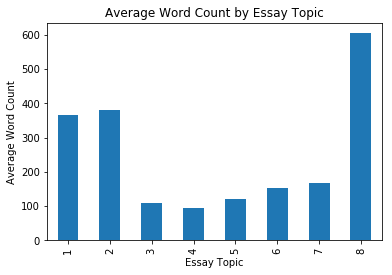

In [0]:
#This graphs the average word count for each essay set
word_count = training_dataset.groupby('essay_set')['word_count'].mean()
word_count.plot(kind = 'bar', title = 'Average Word Count by Essay Topic')
plt.xlabel('Essay Topic')
plt.ylabel('Average Word Count')

Text(0, 0.5, 'Average Score')

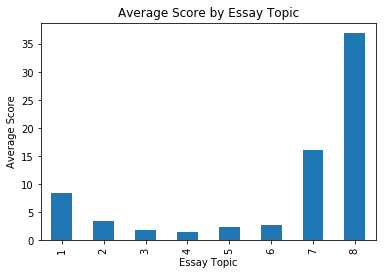

In [0]:
#This graphs the average score for each essay set
mean_set_one = training_dataset.groupby('essay_set')['domain1_score'].mean()
mean_set_one.plot(kind = 'bar', title = 'Average Score by Essay Topic')
plt.xlabel('Essay Topic')
plt.ylabel('Average Score')

In [0]:
#This prints out the shape of the training dataset
training_dataset.shape

(12976, 18)

In [0]:
#This prints out the shape of the testing dataset
testing_dataset.shape

(4254, 5)

# Data Preprocessing 

In [0]:
#This cell standardizes the language amongst all the essays in the training dataset
language_check_tool = language_check.LanguageTool('en-US')

training_dataset['matched_words'] = training_dataset['essay'].apply(lambda txt: language_check_tool.check(txt))
training_dataset['corrected_language'] = training_dataset.apply(lambda l: language_check.correct(l['essay'], l['matched_words']), axis=1)


In [0]:
#This cell standardizes the language amongst all the essays in the testing dataset
language_check_tool = language_check.LanguageTool('en-US')

testing_dataset['matched_words'] = testing_dataset['essay'].apply(lambda txt: language_check_tool.check(txt))
testing_dataset['corrected_language'] = testing_dataset.apply(lambda l: language_check.correct(l['essay'], l['matched_words']), axis=1)


In [0]:
#This cell lemmatizes and tokenizes the essays in the training dataset
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

training_dataset['tokenized']=training_dataset['essay'].apply(nltk.word_tokenize)
training_dataset['lemmatized']=training_dataset['essay'].apply(lambda x: wordnet_lemmatizer.lemmatize(x))

In [0]:
#This cell lemmatizes and tokenizes the essays in the testing dataset
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

testing_dataset['tokenized']=testing_dataset['essay'].apply(nltk.word_tokenize)
testing_dataset['lemmatized']=testing_dataset['essay'].apply(lambda x: wordnet_lemmatizer.lemmatize(x))

# Topic Modeling For All Eight Topics 

In [0]:
list_of_topics = {'topic':{1: 'effect of computers', 
                       2: 'censorship views', 
                       3: 'effect of setting on a cyclist', 
                       4: 'winter hibiscus', 
                       5: 'mood in memoir', 
                       6: 'empire state building and dirigibles', 
                       7: 'patience', 
                       8: 'laughter'}}

training_dataset.replace(list_of_topics, inplace=True)

In [0]:
#This cell converts the training dataset to matrix and finds the most frequent words 
matrixConversion = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=2000) 

lemmatized_matrix_train = matrixConversion.fit_transform(training_dataset.lemmatized) 

words = matrixConversion.get_feature_names()
lemmatized_matrix_df_train = pd.SparseDataFrame(lemmatized_matrix_train, columns=words)
frequency_of_words = lemmatized_matrix_df_train.sum(axis=0).astype(int)
frequency_of_words.sort_values(ascending=False).head() 

C:\Users\teena\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


computers    10697
computer      9391
books         8147
building      7539
book          5862
dtype: int32

In [0]:
#This cell converts the testing dataset to matrix and finds the most frequent words 
matrixConversion = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=2000) 

lemmatized_matrix_test = matrixConversion.fit_transform(testing_dataset.lemmatized) 

words = matrixConversion.get_feature_names()
lemmatized_matrix_df_test = pd.SparseDataFrame(lemmatized_matrix_test, columns=words)
frequency_of_words = lemmatized_matrix_df_test.sum(axis=0).astype(int)
frequency_of_words.sort_values(ascending=False).head() 

C:\Users\teena\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


computers    3536
computer     3022
books        2739
building     2443
book         1862
dtype: int32

In [0]:
#This cell applies LDA to the training dataset
lda = LatentDirichletAllocation(n_components=8,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=30,
                                     perp_tol=0.01,
                                     verbose=1,
                                     evaluate_every=5)
lda.fit(lemmatized_matrix_train)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30, perplexity: 442.2546
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30, perplexity: 440.9416
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30, perplexity: 440.7685
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30, perplexity: 440.7186
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30, perplexity: 440.6989
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=30,
             mean_change_tol=0.001, n_components=8, n_jobs=-1,
             n_topics=None, perp_tol=0.01, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [0]:
#This cell applies LDA to the testing dataset
lda = LatentDirichletAllocation(n_components=8,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=30,
                                     perp_tol=0.01,
                                     verbose=1,
                                     evaluate_every=5)
lda.fit(lemmatized_matrix_test)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30, perplexity: 492.8111
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30, perplexity: 489.5944
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30, perplexity: 488.2641
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30, perplexity: 487.1445
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30, perplexity: 486.4121
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=30,
             mean_change_tol=0.001, n_components=8, n_jobs=-1,
             n_topics=None, perp_tol=0.01, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [0]:
#This cell finds the probability of words appearing in each topic
labels_for_topics = ['Topic {}'.format(i) for i in range(1, 9)]
count_of_topics = lda.components_
probability_of_topics = count_of_topics / count_of_topics.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(probability_of_topics.T,
                      index=words,
                      columns=labels_for_topics)
topics.sample(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
cuban,0.000004,0.000004,0.000012,0.000006,0.000002,0.000004,0.000002,0.005978
turned,0.000004,0.000084,0.000012,0.000155,0.001705,0.000004,0.000027,0.002758
hard,0.000699,0.001386,0.000012,0.004285,0.003765,0.001663,0.000880,0.002686
beauty,0.000004,0.000004,0.000012,0.000063,0.000042,0.000004,0.000184,0.000328
learned,0.000495,0.000305,0.001848,0.000519,0.000835,0.000004,0.000378,0.003123
visit,0.000061,0.000288,0.000012,0.000006,0.000255,0.000004,0.000456,0.000003
research,0.000439,0.000468,0.000012,0.000006,0.000002,0.000004,0.003307,0.000003
attempted,0.000004,0.000092,0.000012,0.000006,0.000079,0.000451,0.000002,0.000003
excited,0.000004,0.000069,0.000012,0.000388,0.001266,0.000004,0.000002,0.000122
strong,0.000004,0.000367,0.000012,0.001061,0.000262,0.002073,0.000196,0.002614


In [0]:
#This cell shows the top 15 words for each topic
top_15_words = {}
for topic, words_ in topics.items():
    top_15_words[topic] = words_.nlargest(15).index.tolist()
pd.DataFrame(top_15_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,books,offensive,caps3,cyclist,got,building,computers,mood
1,children,books,caps4,water,laughter,dirigibles,computer,parents
2,kids,book,caps5,setting,day,state,friends,saeng
3,library,read,caps6,features,patient,empire,use,test
4,movies,library,caps7,affect,said,mast,help,home
5,music,libraries,eye,hot,laugh,builders,don,memoir
6,parents,month1,hand,road,went,mooring,learn,paragraph
7,child,right,caps8,affected,person1,dirigible,world,narciso
8,read,find,coordination,hills,mom,dock,online,hibiscus
9,bad,person,caps9,town,started,faced,internet,love


In [0]:
#This cell makes a prediction dataset and evaluation dataset from training dataset 
training_dataset_prediction = lda.transform(lemmatized_matrix_train)
training_dataset_evaluation = pd.DataFrame(training_dataset_prediction, columns = labels_for_topics, 
                                          index = training_dataset.essay_set)

In [0]:
#This cell makes a prediction dataset and evaluation dataset from the testing dataset
testing_dataset_prediction = lda.transform(lemmatized_matrix_test)
testing_dataset_evaluation = pd.DataFrame(testing_dataset_prediction, columns = labels_for_topics, 
                                          index = testing_dataset.essay_set)

Text(0.5, 1.0, 'Assignment of Topic Predictions (Training Dataset)')

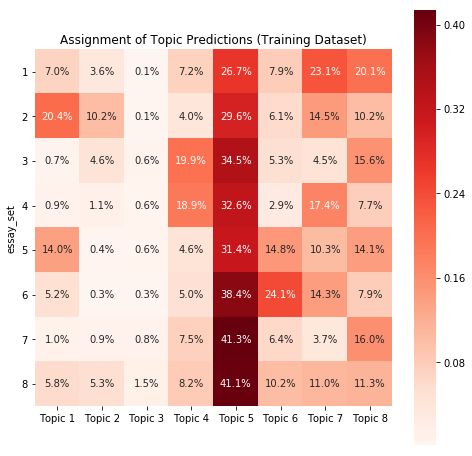

In [0]:
#This cell assigns topics using a heatmap for the training dataset
df = training_dataset_evaluation.groupby(level='essay_set').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Reds', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Assignment of Topic Predictions (Training Dataset)')

Text(0.5, 1.0, 'Assignment of Topic Predictions (Testing Dataset)')

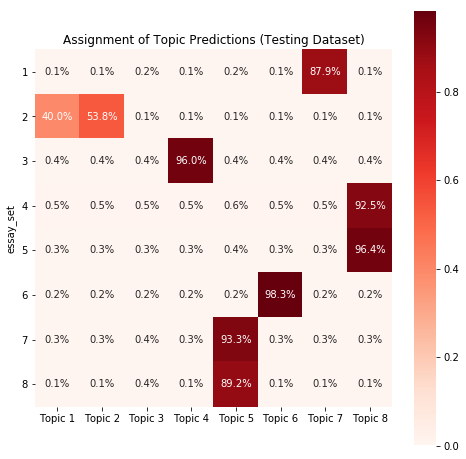

In [0]:
#This cell assigns topics using a heatmap for the testing dataset
df = testing_dataset_evaluation.groupby(level='essay_set').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Reds', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Assignment of Topic Predictions (Testing Dataset)')

# Topic Modeling For Five Topics

In [0]:
#The same procedure as above is followed here and for 'Topic Modeling For Two Topics'
list_of_topics = {'topic':{1: 'effect of computers', 
                       2: 'mood in memoir', 
                       3: 'empire state building and dirigibles', 
                       4: 'patience', 
                       5: 'laughter'}}

training_dataset.replace(list_of_topics, inplace=True)

In [0]:
matrixConversion = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=2000) 

lemmatized_matrix_train = matrixConversion.fit_transform(training_dataset.lemmatized) 

words = matrixConversion.get_feature_names()
lemmatized_matrix_df_train = pd.SparseDataFrame(lemmatized_matrix_train, columns=words)
frequency_of_words = lemmatized_matrix_df_train.sum(axis=0).astype(int)
frequency_of_words.sort_values(ascending=False).head() 

C:\Users\teena\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


computers    10697
computer      9391
books         8147
building      7539
book          5862
dtype: int32

In [0]:
matrixConversion = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=2000) 

lemmatized_matrix_test = matrixConversion.fit_transform(testing_dataset.lemmatized) 

words = matrixConversion.get_feature_names()
lemmatized_matrix_df_test = pd.SparseDataFrame(lemmatized_matrix_test, columns=words)
frequency_of_words = lemmatized_matrix_df_test.sum(axis=0).astype(int)
frequency_of_words.sort_values(ascending=False).head() 

C:\Users\teena\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


computers    3536
computer     3022
books        2739
building     2443
book         1862
dtype: int32

In [0]:
lda = LatentDirichletAllocation(n_components=5,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=30,
                                     perp_tol=0.01,
                                     verbose=1,
                                     evaluate_every=5)
lda.fit(lemmatized_matrix_train)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30, perplexity: 525.6818
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30, perplexity: 512.8638
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30, perplexity: 512.7366
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30, perplexity: 512.7178
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30, perplexity: 512.7085


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=30,
             mean_change_tol=0.001, n_components=5, n_jobs=-1,
             n_topics=None, perp_tol=0.01, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [0]:
lda = LatentDirichletAllocation(n_components=5,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=30,
                                     perp_tol=0.01,
                                     verbose=1,
                                     evaluate_every=5)
lda.fit(lemmatized_matrix_test)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30, perplexity: 537.3996
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30, perplexity: 536.6017
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30, perplexity: 536.5036
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30, perplexity: 536.4858
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30, perplexity: 536.4787


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=30,
             mean_change_tol=0.001, n_components=5, n_jobs=-1,
             n_topics=None, perp_tol=0.01, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [0]:
labels_for_topics = ['Topic {}'.format(i) for i in range(1, 6)]
count_of_topics = lda.components_
probability_of_topics = count_of_topics / count_of_topics.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(probability_of_topics.T,
                      index=words,
                      columns=labels_for_topics)
topics.sample(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
reading,0.000348,0.000951,0.000355,0.000003,0.008045
states,0.002032,0.001881,0.003348,0.000003,0.000110
older,0.000522,0.000109,0.000006,0.000613,0.001195
human,0.000145,0.000644,0.000006,0.000263,0.000684
passage,0.000771,0.000217,0.000290,0.000003,0.000003
mood,0.000665,0.015591,0.000006,0.000248,0.000003
door,0.000005,0.000764,0.000006,0.001469,0.000003
walk,0.000117,0.000342,0.000006,0.001723,0.000549
facebook,0.000005,0.001981,0.000006,0.000003,0.000003
wrong,0.000610,0.000462,0.000274,0.000920,0.003730


In [0]:
#Here, we take a look at the top 15 words for each topic
top_15_words = {}
for topic, words_ in topics.items():
    top_15_words[topic] = words_.nlargest(15).index.tolist()
pd.DataFrame(top_15_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,cyclist,computers,building,got,books
1,saeng,computer,dirigibles,caps3,book
2,test,mood,state,day,offensive
3,water,friends,empire,laughter,library
4,setting,parents,mast,said,read
5,hibiscus,use,builders,patient,libraries
6,paragraph,memoir,mooring,person1,children
7,features,help,dirigible,laugh,movies
8,spring,home,dock,went,music
9,concludes,narciso,faced,mom,kids


In [0]:
training_dataset_prediction = lda.transform(lemmatized_matrix_train)
training_dataset_evaluation = pd.DataFrame(training_dataset_prediction, columns = labels_for_topics, 
                                          index = training_dataset.essay_set)

In [0]:
testing_dataset_prediction = lda.transform(lemmatized_matrix_test)
testing_dataset_evaluation = pd.DataFrame(testing_dataset_prediction, columns = labels_for_topics, 
                                          index = testing_dataset.essay_set)

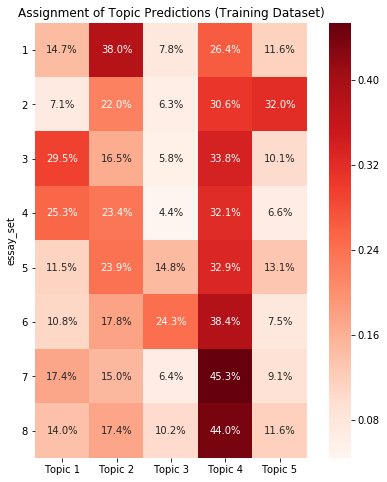

In [0]:
df = training_dataset_evaluation.groupby(level='essay_set').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Reds', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Assignment of Topic Predictions (Training Dataset)');


Text(0.5, 1.0, 'Assignment of Topic Predictions (Testing Dataset)')

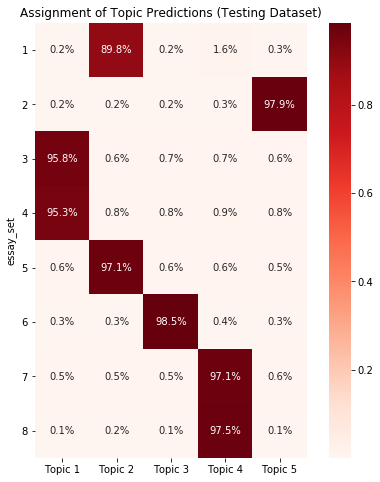

In [0]:
df = testing_dataset_evaluation.groupby(level='essay_set').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Reds', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Assignment of Topic Predictions (Testing Dataset)')

# Topic Modeling For Two Topics

In [0]:
list_of_topics = {'topic':{1: 'effect of computers', 
                       2: 'laughter'}}

training_dataset.replace(list_of_topics, inplace=True)

In [0]:
matrixConversion = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=2000) 

lemmatized_matrix_train = matrixConversion.fit_transform(training_dataset.lemmatized) 

words = matrixConversion.get_feature_names()
lemmatized_matrix_df_train = pd.SparseDataFrame(lemmatized_matrix_train, columns=words)
frequency_of_words = lemmatized_matrix_df_train.sum(axis=0).astype(int)
frequency_of_words.sort_values(ascending=False).head() 


C:\Users\teena\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


computers    10697
computer      9391
books         8147
building      7539
book          5862
dtype: int32

In [0]:
matrixConversion = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=STOP_WORDS, 
                             max_features=2000) 

lemmatized_matrix_test = matrixConversion.fit_transform(testing_dataset.lemmatized) 

words = matrixConversion.get_feature_names()
lemmatized_matrix_df_test = pd.SparseDataFrame(lemmatized_matrix_test, columns=words)
frequency_of_words = lemmatized_matrix_df_test.sum(axis=0).astype(int)
frequency_of_words.sort_values(ascending=False).head() 

C:\Users\teena\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


computers    3536
computer     3022
books        2739
building     2443
book         1862
dtype: int32

In [0]:
lda = LatentDirichletAllocation(n_components=2,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=30,
                                     perp_tol=0.01,
                                     verbose=1,
                                     evaluate_every=5)
lda.fit(lemmatized_matrix_train)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30, perplexity: 793.3024
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30, perplexity: 792.9032
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30, perplexity: 792.8705
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30, perplexity: 792.8640


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=30,
             mean_change_tol=0.001, n_components=2, n_jobs=-1,
             n_topics=None, perp_tol=0.01, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [0]:
lda = LatentDirichletAllocation(n_components=2,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=30,
                                     perp_tol=0.01,
                                     verbose=1,
                                     evaluate_every=5)
lda.fit(lemmatized_matrix_test)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30, perplexity: 760.6181
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30, perplexity: 760.0314
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30, perplexity: 760.0108
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30, perplexity: 760.0060


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.7, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=30,
             mean_change_tol=0.001, n_components=2, n_jobs=-1,
             n_topics=None, perp_tol=0.01, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=1)

In [0]:
labels_for_topics = ['Topic {}'.format(i) for i in range(1, 3)]
count_of_topics = lda.components_
probability_of_topics = count_of_topics / count_of_topics.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(probability_of_topics.T,
                      index=words,
                      columns=labels_for_topics)
topics.sample(10)

,Topic 1,Topic 2
flammable,0.002219,0.000002
smoking,0.000005,0.000130
lazy,0.000005,0.000355
abandoned,0.000613,0.000003
expression,0.000005,0.000144
social,0.000005,0.000692
wouldn,0.000582,0.001691
afford,0.000080,0.000090
person3,0.000005,0.000824
literature,0.000008,0.000305


In [0]:
#Here, we take a look at the top 15 words for each topic
top_15_words = {}
for topic, words_ in topics.items():
    top_15_words[topic] = words_.nlargest(15).index.tolist()
pd.DataFrame(top_15_words)

,Topic 1,Topic 2
0,building,computers
1,mood,computer
2,dirigibles,books
3,state,book
4,cyclist,caps3
5,empire,friends
6,parents,don
7,paragraph,offensive
8,water,read
9,mast,day


In [0]:
training_dataset_prediction = lda.transform(lemmatized_matrix_train)
training_dataset_evaluation = pd.DataFrame(training_dataset_prediction, columns = labels_for_topics, 
                                          index = training_dataset.essay_set)

In [0]:
testing_dataset_prediction = lda.transform(lemmatized_matrix_test)
testing_dataset_evaluation = pd.DataFrame(testing_dataset_prediction, columns = labels_for_topics, 
                                          index = testing_dataset.essay_set)

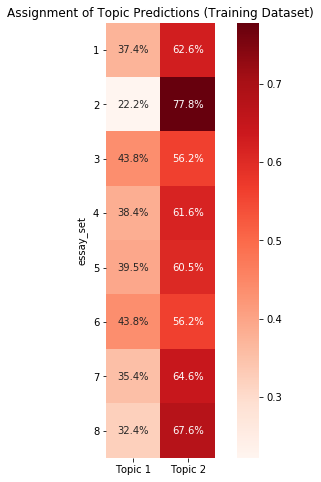

In [0]:
df = training_dataset_evaluation.groupby(level='essay_set').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Reds', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Assignment of Topic Predictions (Training Dataset)');

Text(0.5, 1.0, 'Assignment of Topic Predictions (Testing Dataset)')

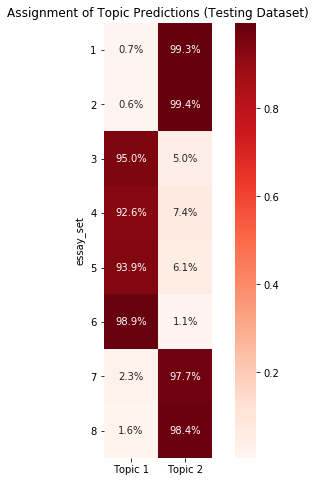

In [0]:
df = testing_dataset_evaluation.groupby(level='essay_set').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Reds', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Assignment of Topic Predictions (Testing Dataset)')